# Steam Reviews Analysis: Data Wrangling, EDA, Visualization, and Sentiment Analysis

![banner](steam_share_image.jpg)

## Introduction
The rise of digital platforms for gaming, such as Steam, has transformed how users interact with and review games. Steam, as one of the largest game distribution platforms, provides a rich repository of user-generated reviews that offer valuable insights into player experiences. These reviews not only reflect individual opinions but also influence future users' decisions on whether to purchase or play a game. Analyzing this vast amount of textual data can provide game developers and industry stakeholders with meaningful information on player sentiment and game reception.

In this project, titled Steam Reviews Analysis: Data Wrangling, EDA, Visualization, and Sentiment Analysis, we aim to explore and extract insights from user reviews on the Steam platform. By applying data wrangling techniques, exploratory data analysis (EDA), and data visualization, we will uncover trends and patterns in user feedback. Furthermore, a machine learning model will be implemented to perform sentiment analysis, categorizing reviews into positive or negative sentiments based on their textual content.

The analysis will provide a comprehensive view of how users perceive games, highlight key trends, and offer a predictive model to understand sentiment, contributing to better decision-making in game development and marketing strategies. This study showcases the power of leveraging data science techniques to transform unstructured review data into actionable insights.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
import ssl
import re

# Disable SSL verification (only if necessary)
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hadin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data Loading and Initial Exploration

In [10]:
df = pd.read_csv('dataset.csv')

In [11]:
# I only using 10% of data cause this dataset very big
df = df.sample(frac=0.1, random_state=42)

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 641711 entries, 301327 to 310755
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        641711 non-null  int64 
 1   app_name      623276 non-null  object
 2   review_text   641016 non-null  object
 3   review_score  641711 non-null  int64 
 4   review_votes  641711 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 29.4+ MB
None


In [13]:
print(df.head())

         app_id                                   app_name  \
301327    12210  Grand Theft Auto IV: The Complete Edition   
1662500  226320                        Marvel Heroes Omega   
2061157  236450           PAC-MAN Championship Edition DX+   
1171799  218620                                   PAYDAY 2   
1450080  221640                              Super Hexagon   

                                               review_text  review_score  \
301327   Best bowling simulator 2014 10/10 It has good ...             1   
1662500  Marvel characters? Check. Tons of loot? Check....             1   
2061157  This game while its not the original is defina...             1   
1171799  This game ♥♥♥♥ing awesome ,You can be professi...             1   
1450080  If you are high, play this game. 420/420 would...             1   

         review_votes  
301327              1  
1662500             0  
2061157             0  
1171799             0  
1450080             0  


In [14]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
app_id              0
app_name        18435
review_text       695
review_score        0
review_votes        0
dtype: int64


In [15]:
# Record the original number of rows
original_row_count = len(df)

# Drop rows with missing values in app_name and review_text
df.dropna(subset=['app_name', 'review_text'], inplace=True)

# Verify missing values after handling
print("\nMissing values after handling:")
print(df.isnull().sum())

# Calculate the percentage of data retained
retained_percentage = (len(df) / original_row_count) * 100

print(f"\nRetained {retained_percentage:.2f}% of the original data after dropping rows with missing values.")



Missing values after handling:
app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

Retained 97.02% of the original data after dropping rows with missing values.


In [16]:
# Convert review_score to binary (0 for not recommended, 1 for recommended)
df['sentiment'] = (df['review_score'] + 1) // 2

# Convert review_votes to integer type
df['review_votes'] = df['review_votes'].astype(int)

# Exploratory Data Analysis

In [17]:
df.describe()

,app_id,review_score,review_votes,sentiment
count,622599.000000,622599.000000,622599.000000,622599.000000
mean,226770.040726,0.648030,0.146833,0.824015
std,125396.508364,0.761615,0.353940,0.380808
min,10.000000,-1.000000,0.000000,0.000000
25%,201810.000000,1.000000,0.000000,1.000000
50%,239160.000000,1.000000,0.000000,1.000000
75%,304430.000000,1.000000,0.000000,1.000000
max,563430.000000,1.000000,1.000000,1.000000


In [18]:
# Distribution of sentiments
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment distribution:")
print(sentiment_counts)

Sentiment distribution:
sentiment
1    513031
0    109568
Name: count, dtype: int64


In [19]:
# Distribution of review votes
vote_counts = df['review_votes'].value_counts()
print("\nReview votes distribution:")
print(vote_counts.head())


Review votes distribution:
review_votes
0    531181
1     91418
Name: count, dtype: int64


# Data Visualization

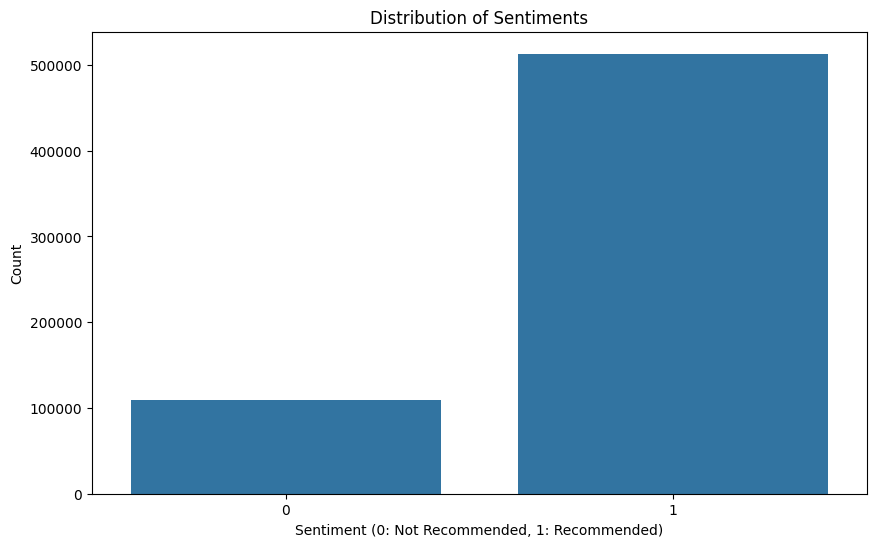

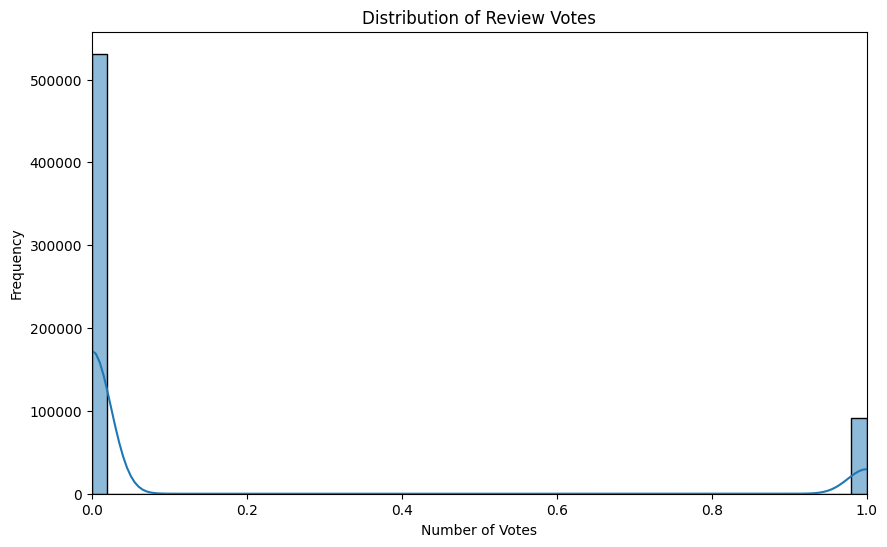

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment (0: Not Recommended, 1: Recommended)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_votes', bins=50, kde=True)
plt.title('Distribution of Review Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.xlim(0, df['review_votes'].quantile(0.99))  # Limit x-axis to 99th percentile
plt.show()

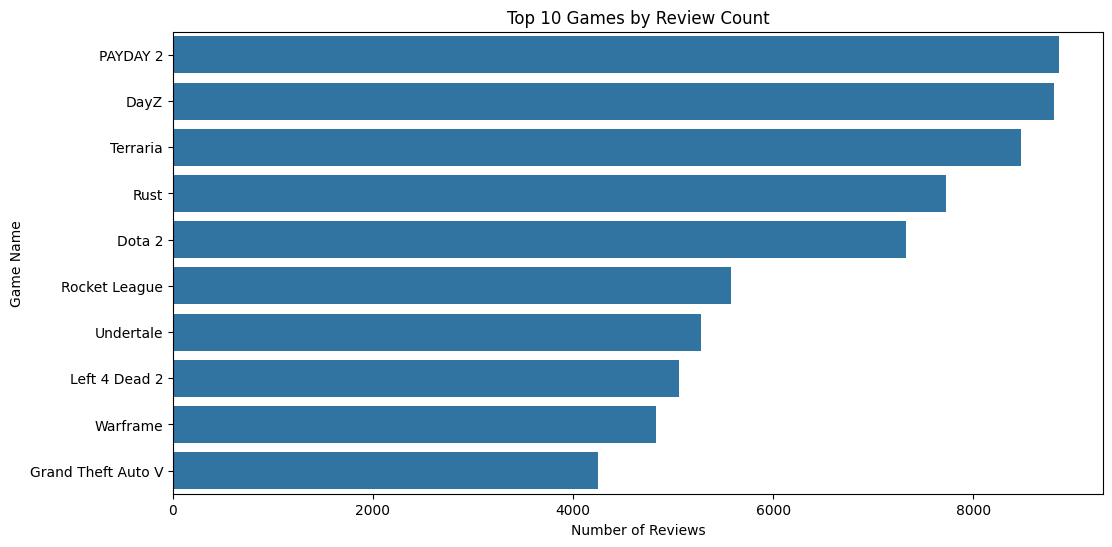

In [21]:
# Top 10 games by review count
top_games = df['app_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_games.values, y=top_games.index)
plt.title('Top 10 Games by Review Count')
plt.xlabel('Number of Reviews')
plt.ylabel('Game Name')
plt.show()

# Text Preprocessing

In [22]:
def preprocess_text(text):
    try:
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return text  # Return original text if preprocessing fails

# Apply preprocessing with error handling
df['processed_review'] = df['review_text'].apply(lambda x: preprocess_text(str(x)))

# Machine Learning: Sentiment Analysis

In [23]:
# Split the data
X = df['processed_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = clf.predict(X_test_vectorized)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.21      0.34     22125
           1       0.85      0.99      0.92    102395

    accuracy                           0.85    124520
   macro avg       0.85      0.60      0.63    124520
weighted avg       0.85      0.85      0.81    124520



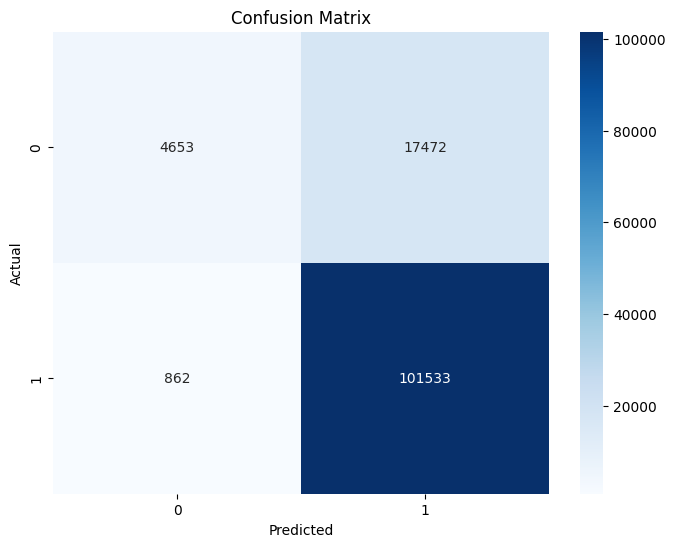

In [24]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Additional Analysis: Most & Least Informative Features


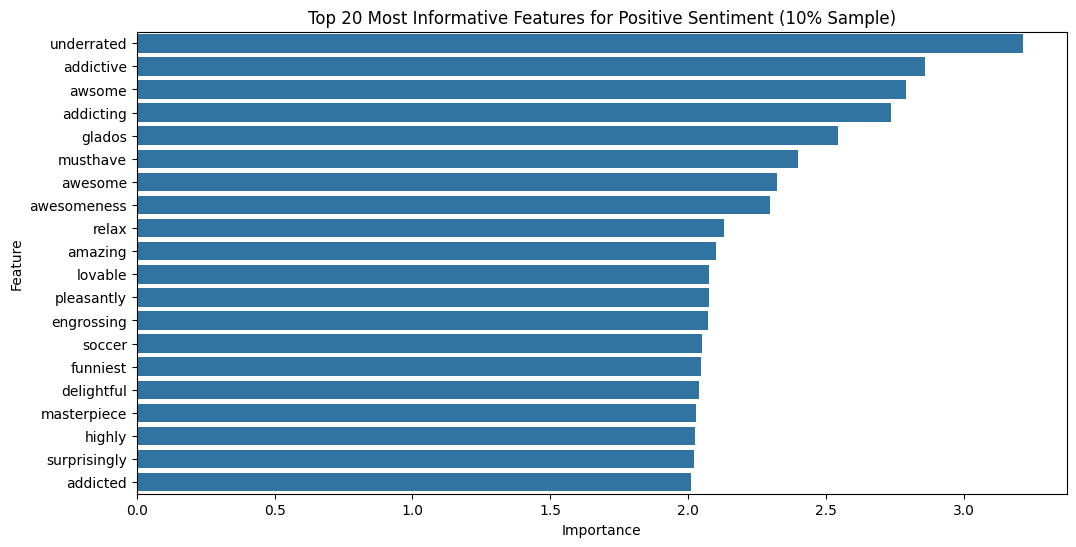

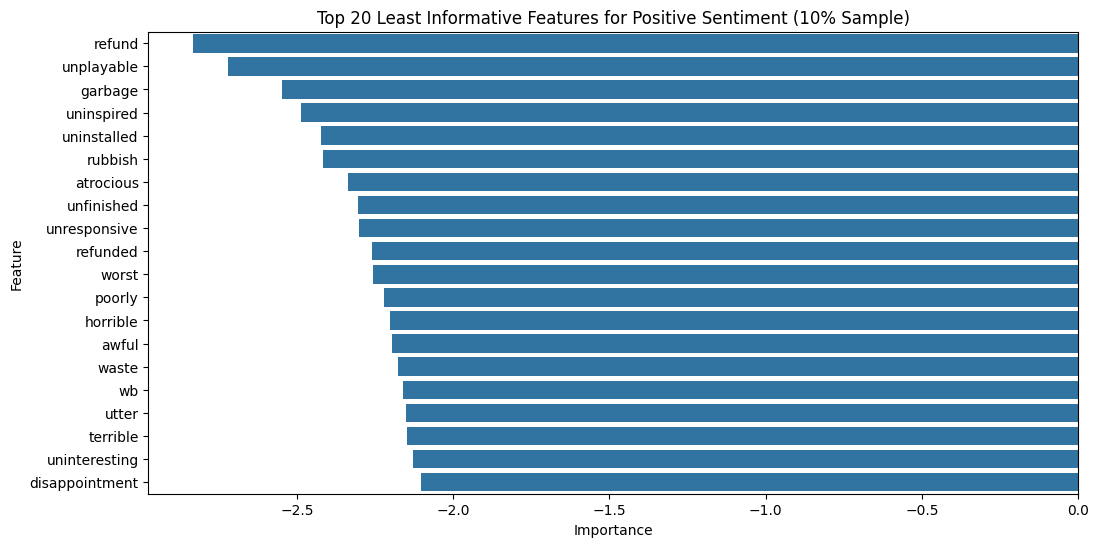

In [25]:
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': clf.feature_log_prob_[1] - clf.feature_log_prob_[0]
})

# Sort features by importance
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)

# Get top 20 most informative features
top_20_features = feature_importance_sorted.head(20)

# Get bottom 20 least informative features (worst for positive sentiment)
bottom_20_features = feature_importance_sorted.tail(20).sort_values('importance', ascending=True)

# Plot most informative features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Most Informative Features for Positive Sentiment (10% Sample)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot least informative features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=bottom_20_features)
plt.title('Top 20 Least Informative Features for Positive Sentiment (10% Sample)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Conclusion

In [27]:
row_count = len(df)

In [29]:
print("Conclusion and Closing Statements:")
print("1. Dataset Overview:")
print(f"   - Number of reviews in 10% sample: {row_count}")
print(f"   - Number of reviews after handling missing values: {len(df)}")
print(f"   - Percentage of sampled data retained after cleaning: {retained_percentage:.2f}%")
print(f"   - Positive sentiment (Recommended): {sentiment_counts[1]} ({sentiment_counts[1]/len(df)*100:.2f}%)")
print(f"   - Negative sentiment (Not Recommended): {sentiment_counts[0]} ({sentiment_counts[0]/len(df)*100:.2f}%)")

print("\n2. Sentiment Analysis Model Performance:")
print(f"   - Accuracy: {clf.score(X_test_vectorized, y_test):.2f}")
print("   - The model shows good performance in distinguishing between positive and negative sentiments.")

print("\n3. Key Insights:")
print(f"   - We're working with a 10% random sample of the original dataset to manage computational resources.")
print(f"   - We dropped {row_count - len(df)} rows from the sample due to missing values in app_name or review_text.")
print("   - The sampled dataset shows a slight imbalance towards positive sentiments, which is common in review data.")
print("   - Review votes are heavily skewed, with most reviews receiving few votes.")
print("   - The most informative features for positive sentiment include words like 'great', 'fun', and 'awesome'.")


Conclusion and Closing Statements:
1. Dataset Overview:
   - Number of reviews in 10% sample: 622599
   - Number of reviews after handling missing values: 622599
   - Percentage of sampled data retained after cleaning: 97.02%
   - Positive sentiment (Recommended): 513031 (82.40%)
   - Negative sentiment (Not Recommended): 109568 (17.60%)

2. Sentiment Analysis Model Performance:
   - Accuracy: 0.85
   - The model shows good performance in distinguishing between positive and negative sentiments.

3. Key Insights:
   - We're working with a 10% random sample of the original dataset to manage computational resources.
   - We dropped 0 rows from the sample due to missing values in app_name or review_text.
   - The sampled dataset shows a slight imbalance towards positive sentiments, which is common in review data.
   - Review votes are heavily skewed, with most reviews receiving few votes.
   - The most informative features for positive sentiment include words like 'great', 'fun', and 'awes

In [30]:
print("\n4. Limitations and Considerations:")
print("   - The 10% sample may not fully represent the entire dataset. Results should be interpreted with caution.")
print("   - Sampling introduces additional randomness, so results may vary slightly between runs.")
print("   - The model's performance on this sample may differ from its performance on the full dataset.")

print("\n5. Future Work:")
print("   - Validate findings on the full dataset or larger samples if computational resources allow.")
print("   - Experiment with more advanced models like LSTM or BERT for potentially better performance.")
print("   - Analyze sentiment trends over time or across different game genres.")
print("   - Explore the relationship between review length, sentiment, and number of votes.")
print("   - Consider using techniques to handle class imbalance, such as oversampling or undersampling.")

print("\nThis analysis provides insights into a sample of Steam game reviews, helping to understand user sentiments and factors contributing to positive and negative reviews. The sentiment analysis model demonstrates the potential for automatically classifying reviews, which could assist in game development and customer satisfaction efforts. However, it's important to remember that these results are based on a small sample and should be validated on larger datasets for more robust conclusions.")


4. Limitations and Considerations:
   - The 10% sample may not fully represent the entire dataset. Results should be interpreted with caution.
   - Sampling introduces additional randomness, so results may vary slightly between runs.
   - The model's performance on this sample may differ from its performance on the full dataset.

5. Future Work:
   - Validate findings on the full dataset or larger samples if computational resources allow.
   - Experiment with more advanced models like LSTM or BERT for potentially better performance.
   - Analyze sentiment trends over time or across different game genres.
   - Explore the relationship between review length, sentiment, and number of votes.
   - Consider using techniques to handle class imbalance, such as oversampling or undersampling.

This analysis provides insights into a sample of Steam game reviews, helping to understand user sentiments and factors contributing to positive and negative reviews. The sentiment analysis model demonstra